In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
emails_df = pd.read_csv("email-Eu-core.txt", sep=" ", header=None, names=["sender", "receiver"])

In [3]:
departments_df = pd.read_csv("email-Eu-core-department-labels.txt", sep=" ", header=None, names=["node", "department"])
department_dict = departments_df.set_index("node")["department"].to_dict()


In [4]:
G = nx.DiGraph()
G.add_edges_from(emails_df.values)
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph has 1005 nodes and 25571 edges.


In [5]:
nx.set_node_attributes(G, department_dict, "department")

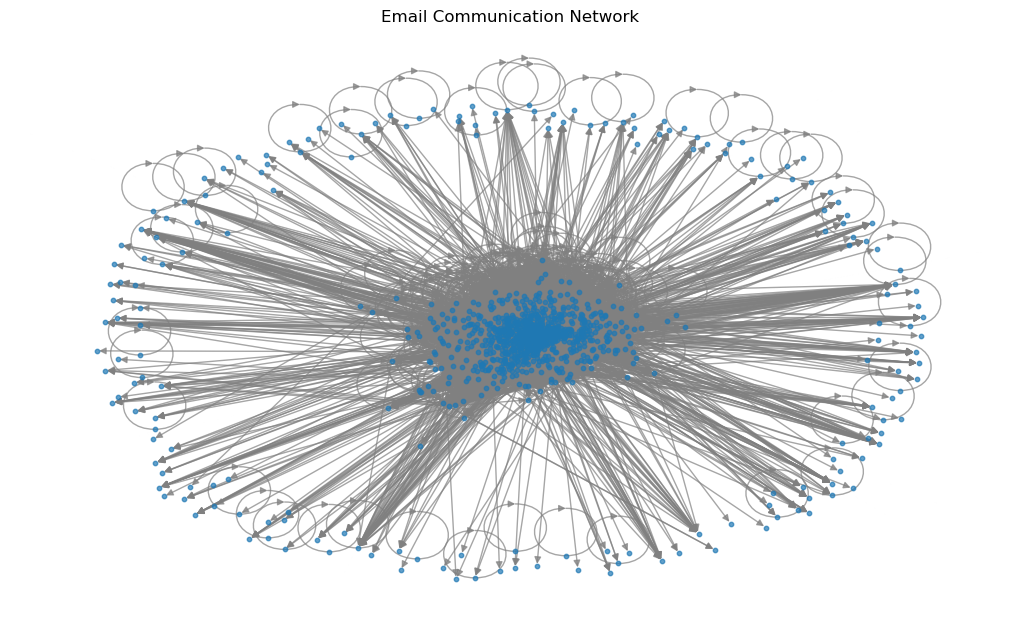

In [6]:
plt.figure(figsize=(10, 6))
nx.draw(G, node_size=10, edge_color="gray", alpha=0.7, with_labels=False)
plt.title("Email Communication Network")
plt.show()

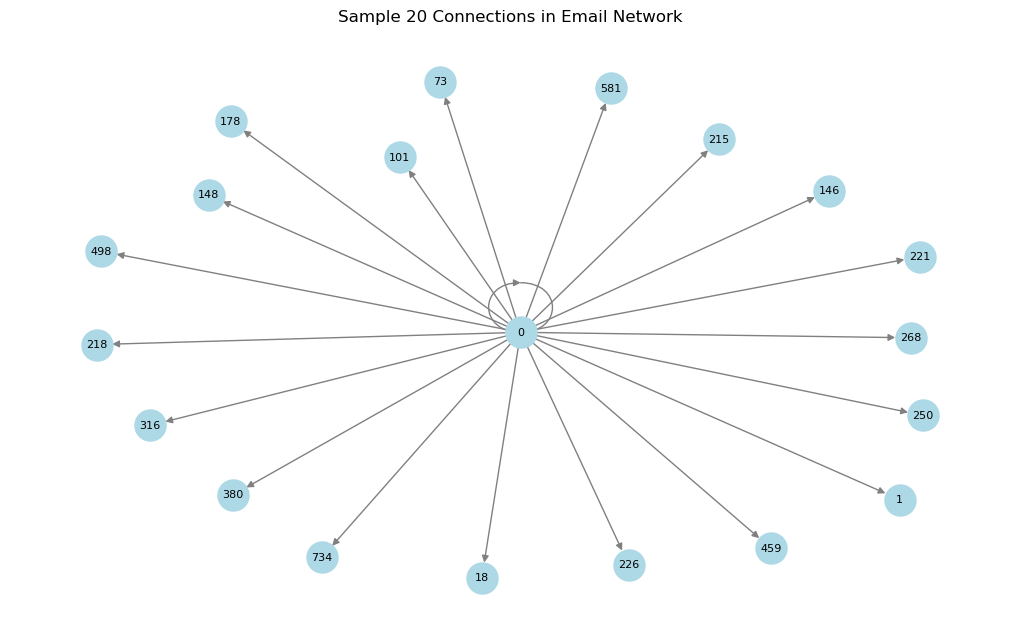

In [7]:
def plot_n_connections(G, n=20):
    sampled_edges = list(G.edges())[:n]
    subgraph = G.edge_subgraph(sampled_edges)
    
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(subgraph)
    nx.draw(subgraph, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=500, font_size=8)
    plt.title(f"Sample {n} Connections in Email Network")
    plt.show()

# Example: Visualizing 20 connections
plot_n_connections(G, n=20)

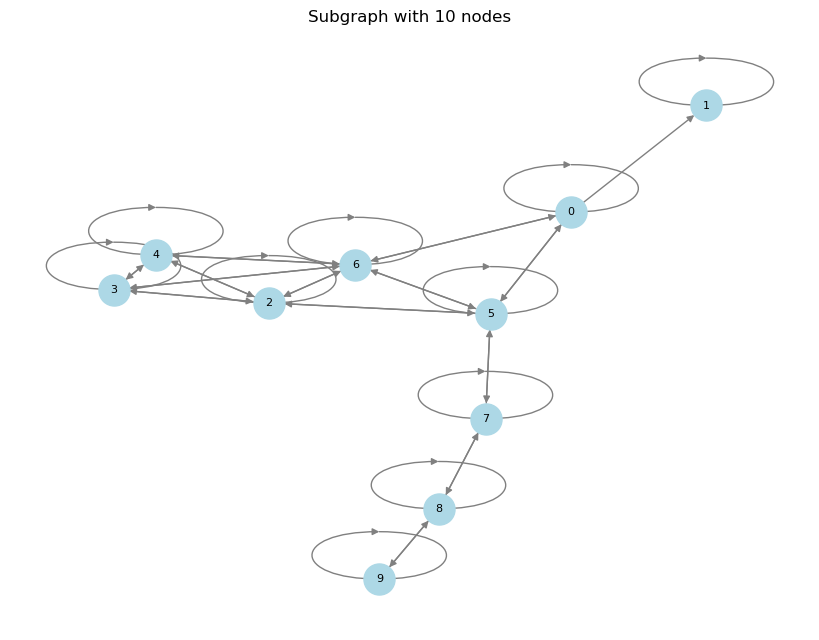

In [8]:
def visualize_subgraph(n=10):
    sub_nodes = list(G.nodes)[:n]
    subgraph = G.subgraph(sub_nodes)

    plt.figure(figsize=(8, 6))
    nx.draw(subgraph, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=8)
    plt.title(f'Subgraph with {n} nodes')
    plt.show()

visualize_subgraph(10)  # Visualize first 10 connections

# Which employees act as "information routers," receiving messages from many and forwarding them to others?

**Why it matters for Telex:**

Identifying these information routers can help Telex suggest automation workflows, such as auto-forwarding important messages to relevant teams.
Helps managers understand who plays a central role in internal communication and reduces information bottlenecks.

**Analysis Approach:**
Compute employees with high in-degree and high out-degree.
Identify those who have a balanced ratio (receive and forward messages instead of keeping them).



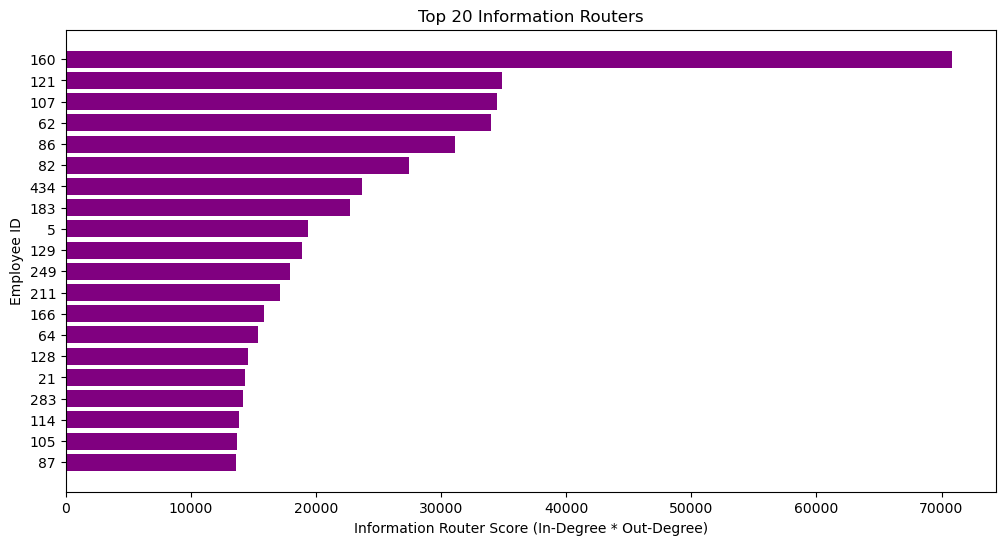

In [10]:
# Compute in-degree (emails received) and out-degree (emails sent)
in_degree = dict(G.in_degree())
out_degree = dict(G.out_degree())

# Compute information router score = (in-degree * out-degree)
info_router_score = {node: in_degree[node] * out_degree[node] for node in G.nodes()}

# Get top 20 information routers
top_routers = sorted(info_router_score.items(), key=lambda x: x[1], reverse=True)[:20]

# Plot
plt.figure(figsize=(12, 6))
plt.barh([str(x[0]) for x in top_routers], [x[1] for x in top_routers], color="purple")
plt.xlabel("Information Router Score (In-Degree * Out-Degree)")
plt.ylabel("Employee ID")
plt.title("Top 20 Information Routers")
plt.gca().invert_yaxis()
plt.show()


# Who are the best-connected employees across the entire company, based on closeness centrality?**
**Why it matters for Telex:**

These are the employees who can quickly spread information across different teams.
Helps Telex recommend faster collaboration routes when setting up workspaces.

**Analysis Approach:**
Compute closeness centrality, which measures how easily an employee can reach others in the network.


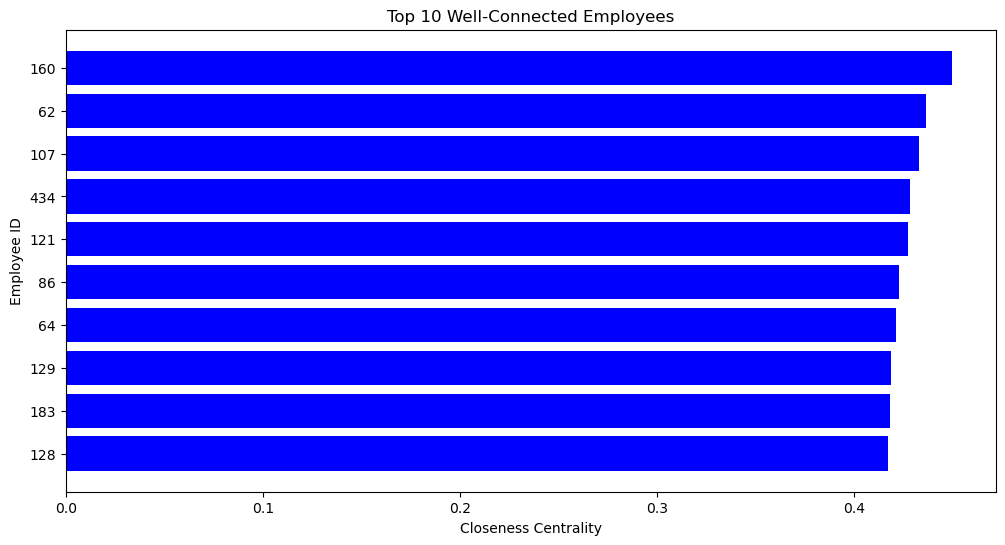

In [12]:
#Compute closeness centrality
closeness_centrality = nx.closeness_centrality(G)

# Get top 20 employees with the highest closeness centrality
top_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

# Plot
plt.figure(figsize=(12, 6))
plt.barh([str(x[0]) for x in top_closeness], [x[1] for x in top_closeness], color="blue")
plt.xlabel("Closeness Centrality")
plt.ylabel("Employee ID")
plt.title("Top 10 Well-Connected Employees")
plt.gca().invert_yaxis()
plt.show()


# Are there employees who are "hidden influencers"—those who rarely send emails but are central to many communication paths?**

**Why it matters for Telex:**

These employees don’t initiate conversations often but still play a critical role in how information spreads.
Telex can suggest improved message tagging or prioritized notifications for these users.

**Analysis Approach:**
Compute betweenness centrality, which identifies employees who frequently appear on shortest paths between other employees.

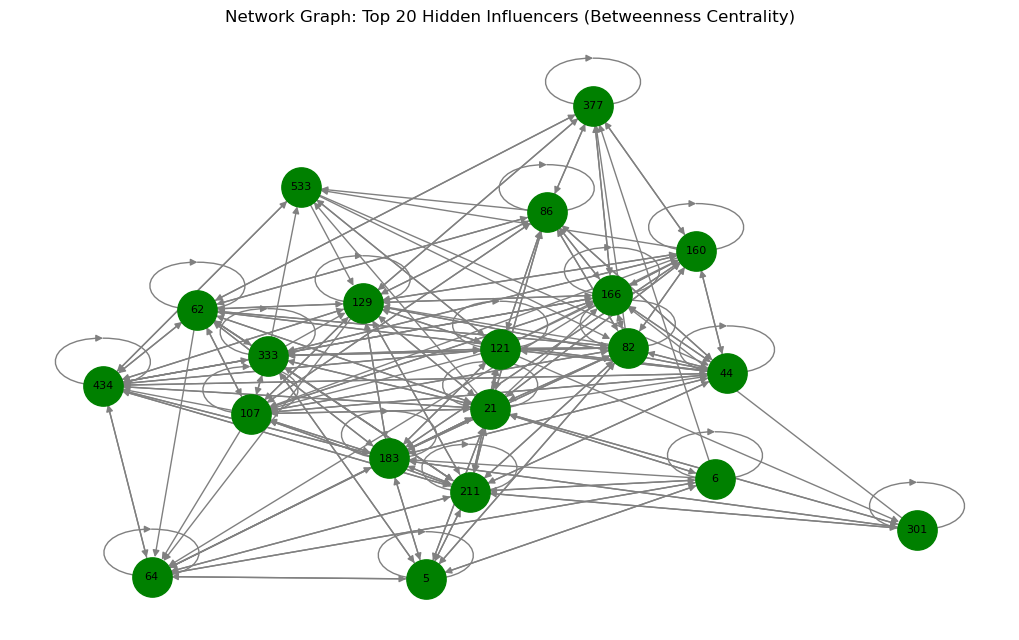

In [14]:
# Compute betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Get top 20 hidden influencers based on betweenness centrality
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:20]

# Extract top influencer IDs
top_nodes = [x[0] for x in top_betweenness]

# Create a subgraph containing only the top 20 influencers and their connections
subG = G.subgraph(top_nodes)

# Visualize the network
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(subG)  # Position nodes for clarity
nx.draw(subG, pos, with_labels=True, node_size=800, node_color="green", edge_color="gray", font_size=8)
plt.title("Network Graph: Top 20 Hidden Influencers (Betweenness Centrality)")
plt.show()


# Which departments have the most centralized communication, where a few employees control most of the email flow?**
**Why it matters for Telex:**

Identifies which departments are the most well-connected within the company. Telex can suggest auto-generated chat groups for departments with high connectivity. Detects which departments need better integration with others.

**Analysis Approach:**
Degree Centrality. It directly measures how many connections a node has (how many people an employee communicates with).

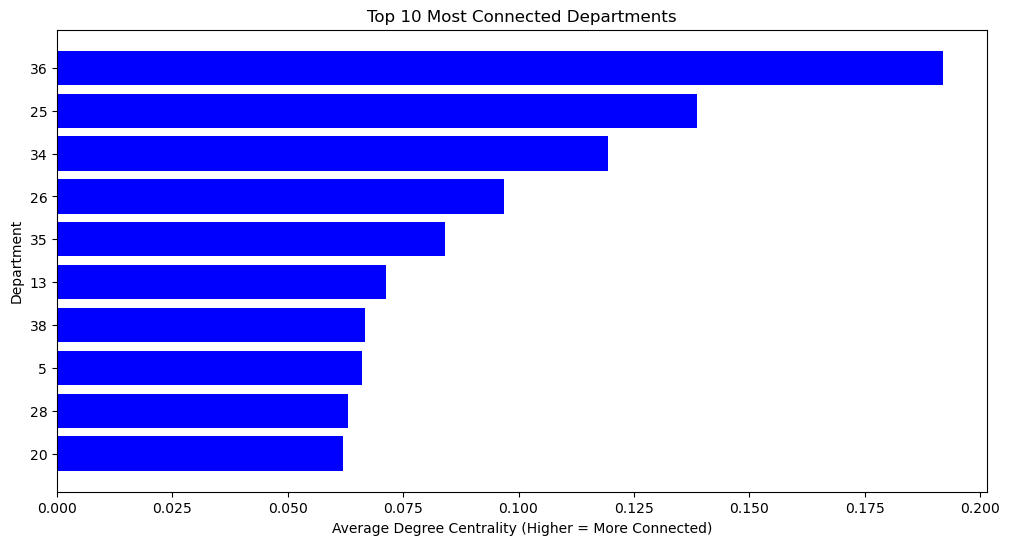

In [16]:
# Compute degree centrality for all employees
degree_centrality = nx.degree_centrality(G)

# Convert degree centrality to DataFrame
degree_centrality_df = pd.DataFrame(degree_centrality.items(), columns=["Employee", "Degree_Centrality"])

# Merge department information
degree_centrality_df = degree_centrality_df.merge(departments_df, left_on="Employee", right_on="node")

# Compute average degree centrality per department
dept_degree_centrality = degree_centrality_df.groupby("department")["Degree_Centrality"].mean().reset_index()

# Get the top 10 departments by average degree centrality
top_10_dept = dept_degree_centrality.nlargest(10, "Degree_Centrality")

# Plot
plt.figure(figsize=(12, 6))
plt.barh(top_10_dept["department"].astype(str), top_10_dept["Degree_Centrality"], color="blue")
plt.xlabel("Average Degree Centrality (Higher = More Connected)")
plt.ylabel("Department")
plt.title("Top 10 Most Connected Departments")
plt.gca().invert_yaxis()
plt.show()

# How do teams naturally cluster, and does this align with official departments?**
**Why it matters for Telex:**

Helps Telex recommend chat channels that reflect real-world communication rather than rigid departmental structures.
Identifies hidden teams working together often.


**Analysis Approach:**
Use Louvain community detection to identify natural communication clusters.

In [18]:
import community as community_louvain

# Compute Louvain communities
partition = community_louvain.best_partition(G.to_undirected())

# Convert partition result into a DataFrame
cluster_df = pd.DataFrame(list(partition.items()), columns=["Employee", "Cluster"])

# Find the largest cluster
largest_cluster_id = cluster_df["Cluster"].value_counts().idxmax()  # Get the ID of the largest cluster
largest_cluster_nodes = cluster_df[cluster_df["Cluster"] == largest_cluster_id]["Employee"].tolist()

# Create a subgraph with only the **largest cluster**
subG = G.subgraph(largest_cluster_nodes)

# Compute network metrics
degree_centrality = nx.degree_centrality(subG)
betweenness_centrality = nx.betweenness_centrality(subG)
closeness_centrality = nx.closeness_centrality(subG)

# Create a DataFrame for the largest cluster
largest_cluster_df = pd.DataFrame({
    "Employee": list(subG.nodes()),
    "Degree": [subG.degree(n) for n in subG.nodes()],
    "Degree Centrality": [degree_centrality[n] for n in subG.nodes()],
    "Betweenness Centrality": [betweenness_centrality[n] for n in subG.nodes()],
    "Closeness Centrality": [closeness_centrality[n] for n in subG.nodes()]
})

# Sort by Degree Centrality (most connected first)
largest_cluster_df = largest_cluster_df.sort_values(by="Degree Centrality", ascending=False)

# Display the first 20 rows
print(largest_cluster_df.head(20))

     Employee  Degree  Degree Centrality  Betweenness Centrality  \
50        121     190           0.612903                0.056592   
41        107     186           0.600000                0.052639   
40        106     178           0.574194                0.042279   
12         62     170           0.548387                0.038961   
26         82     165           0.532258                0.034140   
7          21     155           0.500000                0.038072   
89        249     140           0.451613                0.016766   
99        282     139           0.448387                0.020411   
148       434     136           0.438710                0.020948   
4          17     134           0.432258                0.026253   
39        105     132           0.425806                0.013940   
54        142     128           0.412903                0.021363   
30         87     126           0.406452                0.019616   
21         74     125           0.403226        

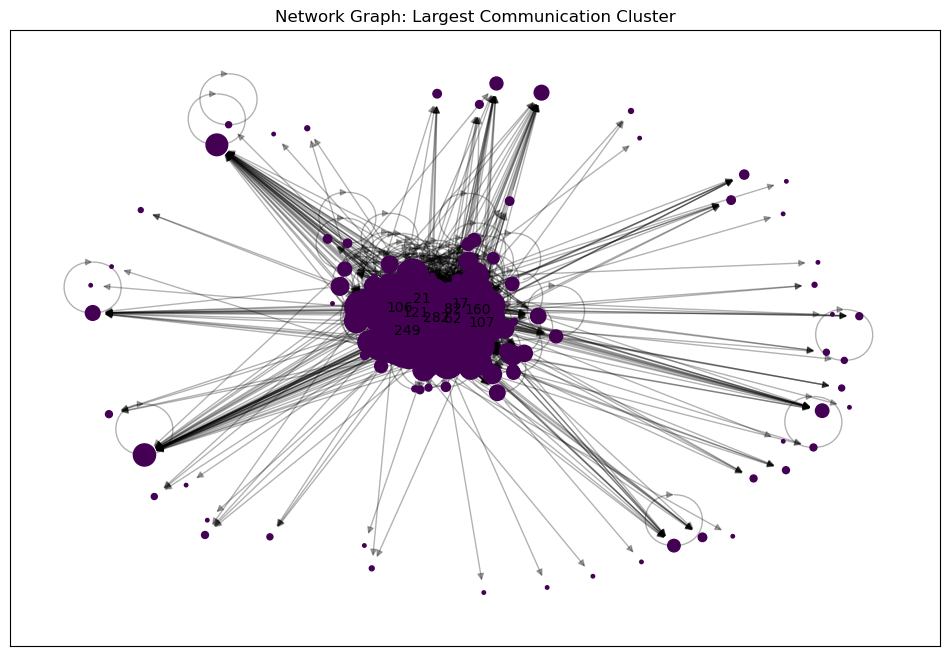

In [19]:
import community as community_louvain

# Compute Louvain communities
partition = community_louvain.best_partition(G.to_undirected())

# Convert partition result into a DataFrame
cluster_df = pd.DataFrame(list(partition.items()), columns=["Employee", "Cluster"])

# Find the largest cluster
largest_cluster_id = cluster_df["Cluster"].value_counts().idxmax()  # Get the ID of the largest cluster
largest_cluster_nodes = cluster_df[cluster_df["Cluster"] == largest_cluster_id]["Employee"].tolist()

# Create a subgraph with only the **largest cluster**
subG = G.subgraph(largest_cluster_nodes)

# Compute degree centrality to scale node size
degree_centrality = nx.degree_centrality(subG)

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subG)  # Node positioning

# Draw nodes
nx.draw_networkx_nodes(subG, pos, 
                       node_color=[partition[n] for n in subG.nodes()], 
                       cmap=plt.get_cmap("viridis"), 
                       node_size=[degree_centrality[n] * 2000 for n in subG.nodes()])

# Draw edges
nx.draw_networkx_edges(subG, pos, alpha=0.3)

# Draw labels for the most central nodes
important_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:10]  # Show top 10 labels
nx.draw_networkx_labels(subG, pos, labels={n: str(n) for n in important_nodes}, font_size=10, font_color="black")

# Show the graph
plt.title("Network Graph: Largest Communication Cluster")
plt.show()

# Which employees act as "silent connectors," bridging different teams but rarely initiating communication?**

**Why it matters for Telex:**
These individuals don’t send many emails but are vital links between different teams.
Helps Telex suggest automatic updates or direct channels for these employees to streamline collaboration.

**Analysis Approach:**
Compute betweenness centrality (measures how often a node appears on shortest paths between others).
Filter employees with low out-degree (they don’t send many emails).
Visualize the network where these employees are highlighted as connectors.

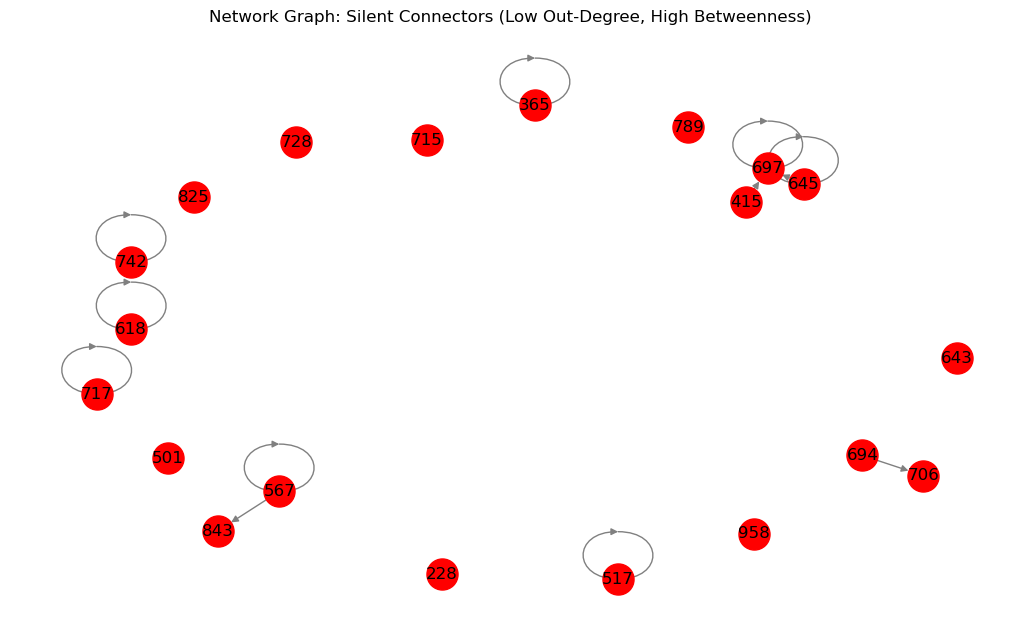

In [21]:
# Compute betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Compute out-degree (emails sent)
out_degree = dict(G.out_degree())

# Identify "silent connectors" (high betweenness, low out-degree)
silent_connectors = {node: betweenness_centrality[node] for node in G.nodes() if out_degree[node] < 5}  # Sent less than 5 emails

# Get top 20 silent connectors
top_silent_connectors = sorted(silent_connectors.items(), key=lambda x: x[1], reverse=True)[:20]

# Extract the top silent connectors' IDs
top_silent_nodes = [x[0] for x in top_silent_connectors]

# Create a subgraph with only the top silent connectors and their connections
subG = G.subgraph(top_silent_nodes)

# Visualize the network graph
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(subG)  # Node positioning
nx.draw(subG, pos, with_labels=True, node_size=500, node_color="red", edge_color="gray")
plt.title("Network Graph: Silent Connectors (Low Out-Degree, High Betweenness)")
plt.show()


# Who are the “Hidden Gatekeepers” in the Organization?**

**Why it matters for Telex:**

Hidden gatekeepers control the flow of information but may not be obvious in terms of email volume.
If they leave or are overloaded, communication breakdowns may occur.
Telex can suggest backup communicators or introduce AI-powered message rerouting.

**Analysis Approach:**
We identify hidden gatekeepers by high betweenness centrality (control over information paths) but low out-degree (not sending many emails themselves).
These are employees 

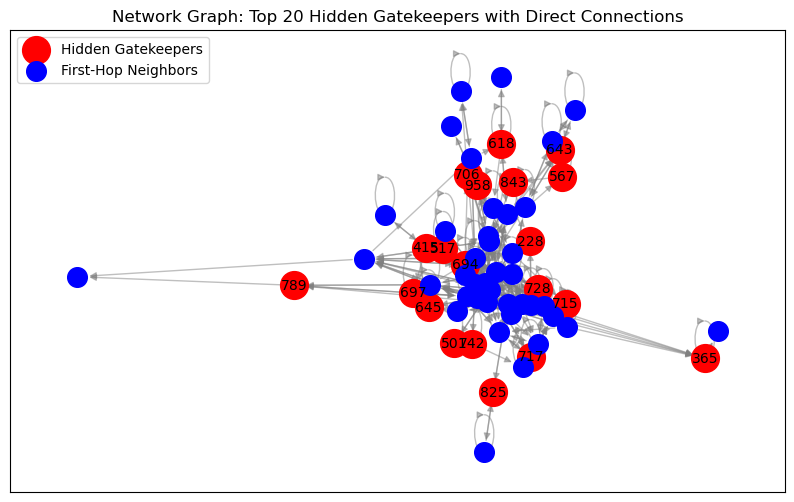

In [56]:
# Compute betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Compute out-degree (emails sent)
out_degree = dict(G.out_degree())

# Identify hidden gatekeepers: high betweenness, low out-degree
hidden_gatekeepers = {node: betweenness_centrality[node] for node in G.nodes() if out_degree[node] < 5}  # Low out-degree

# Get top 20 hidden gatekeepers
top_gatekeepers = [x[0] for x in sorted(hidden_gatekeepers.items(), key=lambda x: x[1], reverse=True)[:20]]

# Include immediate neighbors of the top gatekeepers for context
subgraph_nodes = set(top_gatekeepers)
for node in top_gatekeepers:
    subgraph_nodes.update(G.neighbors(node))  # Add first-degree connections

# Create the subgraph
G_sub = G.subgraph(subgraph_nodes)

# Check if subgraph has nodes before plotting
if len(G_sub.nodes) > 0:
    # Network Visualization
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G_sub)  # Positioning nodes

    # Draw subgraph edges
    nx.draw_networkx_edges(G_sub, pos, alpha=0.5, edge_color="gray")

    # Draw hidden gatekeepers (red)
    nx.draw_networkx_nodes(G_sub, pos, nodelist=top_gatekeepers, node_color="red", node_size=400, label="Hidden Gatekeepers")

    # Draw first-degree neighbors (blue)
    nx.draw_networkx_nodes(G_sub, pos, nodelist=set(G_sub.nodes()) - set(top_gatekeepers), node_color="blue", node_size=200, label="First-Hop Neighbors")

    # Add labels only to hidden gatekeepers
    nx.draw_networkx_labels(G_sub, pos, labels={n: str(n) for n in top_gatekeepers}, font_size=10, font_color="black")

    plt.legend()
    plt.title("Network Graph: Top 20 Hidden Gatekeepers with Direct Connections")
    plt.show()
else:
    print("No connected subgraph found for the top gatekeepers.")
